In [1]:
import numpy as np
import string
import random
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
from torch.nn import ReLU, Tanh,Sigmoid
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, IterableDataset, DataLoader

In [3]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_CLASSES = 26
MIN_LEN = 5
MAX_LEN = 10

In [4]:
#Function list contains all the functions to sample from. 
#In case of 'bogus' is sampled, a random function name is generated using gen_word() function below
function_list = ['first', 'last', 'freq', 'next', 'bogus'] 

In [5]:
alphabets = list(string.ascii_lowercase) #List of alphabets

In [6]:
def gen_word(func = True,  min=MIN_LEN, max=MAX_LEN):
  '''Generates a random word, which can be used as an input or a function name of bogus functions'''
  word = ''
  syllables = min + int(random.random() * (max - min))
  for i in range(0, syllables):
    if (func):
      word += random.choice(alphabets)
    else:
      #Add a space between letters if not a function
      word = word + " " + random.choice(alphabets) 
  return word

In [7]:
def get_encoded_input(s):
  '''Encodes a given string to input format with function name, input, first_or_last position encoded'''
  tokens = s.split()
  #print(tokens)
  func = tokens[0]
  input_str = tokens[1:]

  encoded_func = [0]*len(alphabets)
  encoded_input = [0]*len(alphabets)
  encoded_f_or_l = [0]*len(alphabets) #Encodes first or last position
  

  #Update first or last flag
  if func == 'first':
    encoded_f_or_l[alphabets.index(tokens[1])] = 1
  elif func == 'last' or func == 'next':
    encoded_f_or_l[alphabets.index(tokens[-1])] = 1

  #Encode function_name
  try:
    for char in func:
      encoded_func[alphabets.index(char)] += 1
  except Exception as e:
    print('Not a valid function name: ' + str(e))

  #Encode input string
  try:
    for char in input_str:
      if(func == 'freq'):
        encoded_input[alphabets.index(char)] += 1
      else:
        encoded_input[alphabets.index(char)] = 1
  except Exception as e:
    print('Invalid letter ' + str(e))

  return encoded_func+ encoded_input+ encoded_f_or_l

In [8]:
def decode_input(encoded_input):
  '''Function to check the encoded input ignoring letter count'''
  #print(encoded_input)
  z= ''
  for i,x in enumerate(encoded_input[:-len(alphabets)]):
    
    if(i< len(alphabets) and x!=0):
      z = z + alphabets[i]
    else:
      if(x!=0):
        z = z + ' ' + alphabets[i - len(alphabets)] 
    
  return z

In [9]:
def simulate_sample(func, max_input_len = MAX_LEN):
  '''Simulates a single example. Takes function name and input length and simulates an encoded input,output pair'''

  #Generate random function name if func = 'bogus'
  if(func not in function_list or func == 'bogus'):
    func = gen_word()

  #Generate random size input string. If freq func, artificially increase freq of any one letter with prob 0.90 
  input_str = gen_word(False,5,max_input_len)
  r = random.random()
  #print(r)
  #print(input_str)
  if (func == 'freq' and r > 0.10):
    input_str = input_str[:-1]+ random.choice(input_str.split())  

  #Join function and input string 
  s = func + input_str
  #print(s)

  #Get encoded input
  encoded_input = get_encoded_input(s)
  encoded_func = encoded_input[:len(alphabets)]
  encoded_str = encoded_input[len(alphabets): - len(alphabets)]
  encoded_f_or_l = encoded_input[-len(alphabets):]

  
  #Generating Output for above generated input
  output = [0]*(len(alphabets)+1)
  
  if (func == 'first'):
    output[encoded_f_or_l.index(1)] = 1
  elif (func == 'last'):
    output[len(encoded_f_or_l)-encoded_f_or_l[::-1].index(1)-1] = 1
  elif (func == 'freq'):
    output[encoded_str.index(max(encoded_str))] = 1
  elif (func == 'next'):
    if (input_str[-1] == 'z'):
      #If z then a
      output[0] = 1
    else:
      output[len(encoded_f_or_l)-encoded_f_or_l[::-1].index(1)] = 1
  else:
    output[-1] = 1

  assert len(encoded_input) == 3*len(alphabets), 'Input is invalid.'
  assert len(encoded_func) == len(alphabets), 'Problem in function name.'
  assert len(encoded_str) == len(alphabets), 'Problem in input string.'
  assert len(encoded_f_or_l) == len(alphabets), 'Problem in first or last flag.'
  assert len(output) == len(alphabets)+1, 'Output is not proper.'

  return encoded_input, output

In [10]:
def simulate_batch(n_batch= BATCH_SIZE, max_input_len=MAX_LEN):
  batch = []
  Y = []
  n_samples = BATCH_SIZE*n_batch
  for i in range(n_samples):
    func = random.choice(function_list)
    instring, label = simulate_sample(func, max_input_len)
    batch.append(instring)
    Y.append(label)
  return np.array(batch),np.array(Y)

In [11]:
def decode_single_output(output):
  '''Return alphabet given index'''
  #print(output)
  if(output>len(alphabets) -1):
    return 0
  else:
    return alphabets[output]

def decode_batch_output(batches):
  '''Returns letter output of a batch. Output should be squeezed to list with len of batches'''
  output = []
  for batch in batches:
    batch_o = []
    for o in batch:
      batch_o.append(decode_single_output(o))
    output.append(batch_o)

  return output

**Create Dataset and Dataloader**

In [12]:
class ClassifierDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
        
    def __len__ (self):
        return len(self.Y)

In [13]:
train_X, train_Y = simulate_batch(1024)
val_X, val_Y = simulate_batch(256)
test_X, test_Y = simulate_batch(256)

In [15]:
test_Y.shape

(4096, 27)

In [14]:
train_data = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())
val_data = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())
test_data = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

**Define the network**

In [16]:
class Net(nn.Module):
  def __init__(self, num_feature, num_class):
    super(Net, self).__init__()
    
    self.layer_1 = nn.Linear(num_feature, 512)
    self.layer_2 = nn.Linear(512, 128)
    self.layer_3 = nn.Linear(128, 64)
    self.layer_out = nn.Linear(64, num_class) 
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.batchnorm1 = nn.BatchNorm1d(512)
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.batchnorm3 = nn.BatchNorm1d(64)
      
  def forward(self, x):
    x = self.layer_1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    
    x = self.layer_2(x)
    x = self.batchnorm2(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.layer_3(x)
    x = self.batchnorm3(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.layer_out(x)
    
    return x

model = Net(num_feature = len(alphabets)*3, num_class=len(alphabets)+1)
print(model)

Net(
  (layer_1): Linear(in_features=78, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=27, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Training the Model**



In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

Net(
  (layer_1): Linear(in_features=78, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=27, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
def prediction_acc(y_pred, y_true):
  '''Returns prediction accuracy for a batch of output'''
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_true).float()
  acc = correct_pred.sum() / len(correct_pred)
  acc = acc * 100
  
  return acc

In [20]:
#Dictionary to store accuracy and loss stats
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [21]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for i, data in enumerate(train_loader):
      X_train_batch, y_train_batch = data
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      labels = torch.max(y_train_batch, 1)[1]
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      
      train_loss = criterion(y_train_pred, labels)
      train_acc = prediction_acc(y_train_pred, labels)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()


    # Validation    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            labels = torch.max(y_val_batch, 1)[1]
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, labels)
            val_acc = prediction_acc(y_val_pred, labels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Begin training.


 10%|█         | 1/10 [00:04<00:36,  4.09s/it]

Epoch 001: | Train Loss: 1.46727 | Val Loss: 0.26329 | Train Acc: 62.109| Val Acc: 95.068


 20%|██        | 2/10 [00:08<00:32,  4.06s/it]

Epoch 002: | Train Loss: 0.52485 | Val Loss: 0.13693 | Train Acc: 86.749| Val Acc: 96.411


 30%|███       | 3/10 [00:11<00:28,  4.00s/it]

Epoch 003: | Train Loss: 0.36539 | Val Loss: 0.10811 | Train Acc: 90.332| Val Acc: 96.777


 40%|████      | 4/10 [00:15<00:23,  3.98s/it]

Epoch 004: | Train Loss: 0.31076 | Val Loss: 0.09310 | Train Acc: 91.644| Val Acc: 97.192


 50%|█████     | 5/10 [00:19<00:19,  3.99s/it]

Epoch 005: | Train Loss: 0.26875 | Val Loss: 0.09887 | Train Acc: 92.560| Val Acc: 97.144


 60%|██████    | 6/10 [00:23<00:16,  4.01s/it]

Epoch 006: | Train Loss: 0.23711 | Val Loss: 0.09271 | Train Acc: 93.335| Val Acc: 97.217


 70%|███████   | 7/10 [00:28<00:12,  4.10s/it]

Epoch 007: | Train Loss: 0.20445 | Val Loss: 0.08021 | Train Acc: 94.427| Val Acc: 97.559


 80%|████████  | 8/10 [00:31<00:07,  3.99s/it]

Epoch 008: | Train Loss: 0.18296 | Val Loss: 0.08533 | Train Acc: 94.586| Val Acc: 97.656


 90%|█████████ | 9/10 [00:35<00:03,  3.98s/it]

Epoch 009: | Train Loss: 0.17010 | Val Loss: 0.07497 | Train Acc: 95.148| Val Acc: 97.754


100%|██████████| 10/10 [00:39<00:00,  4.00s/it]

Epoch 010: | Train Loss: 0.16008 | Val Loss: 0.07177 | Train Acc: 95.422| Val Acc: 98.047


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

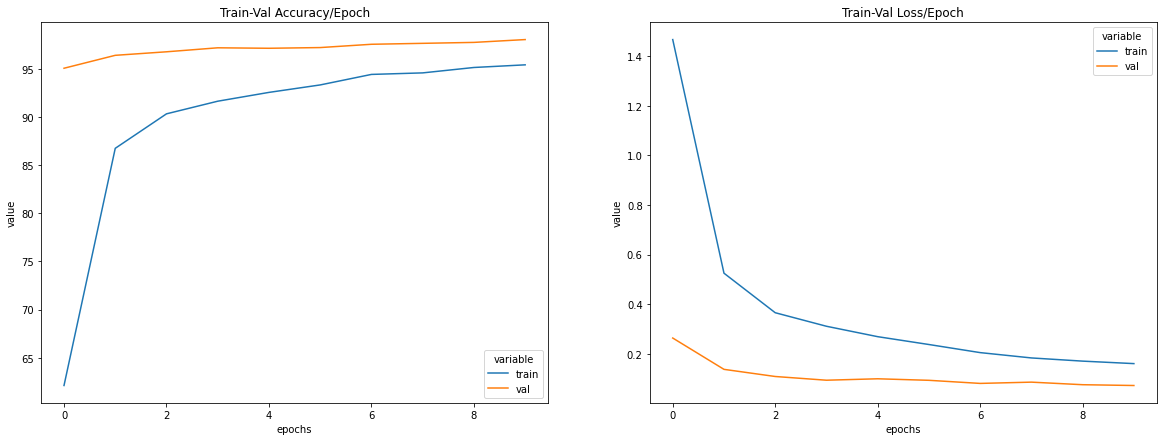

In [22]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

**Prediction**

In [23]:
def predict(model, input_str):
  '''Function to predict single input string'''
  model.eval()
  encoded_input = get_encoded_input(input_str)
  encoded_input = torch.from_numpy(np.array(encoded_input)).float()
  encoded_input = encoded_input.view(1,len(alphabets)*3)
  encoded_input = encoded_input.to(device)
  y_pred = model(encoded_input)
  y_pred = torch.log_softmax(y_pred, dim = 1)
  _, prediction = torch.max(y_pred, dim = 1)
  prediction = prediction.detach().cpu().numpy()[0]
  out = decode_single_output(prediction)
  return out

In [24]:
predict(model, 'next d f j k f m f o p')

'q'

In [25]:
predict(model, 'freq d f j k f m f o p')

'f'

In [26]:
predict(model, "freqd f j k f m f o p") 

'k'

In [31]:
predict(model, "first f j k f m f o p") 

'f'

In [28]:
predict(model, "asfjklasdsfgffdh a r l m n o h n u s a f p k m p l g a t u l")  #Can handle any length of function name

0

In [32]:
predict(model, "freq a r l m n o h n u s a f p k m p l g a t u l")  #Can handle any length of input

'l'

In [33]:
predict(model, "last a r l m n o h n u s a f p k m p l g a t u l")  #Can handle any length of input

'l'

In [34]:
predict(model, "next a r l m n p l g a t u l z")  #Next letter when last is z

'a'

In [35]:
predict(model, "asdf12 a r l m n p l g a t u l z")  #Invalid function name

Not a valid function name: '1' is not in list


0

In [38]:
predict(model, "asdf a r l 2334 a t u l z")  #Invalid sring

Invalid letter '2334' is not in list


0

In [39]:
predict(model, "asdf1344 a r l 86576 a t u l z")  #Invalid function and string

Not a valid function name: '1' is not in list
Invalid letter '86576' is not in list


0